<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/exoplanet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exoplanet Research**

In [ ]:
!pip install lightkurve astroquery -q
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import re
from astropy import units as u
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
import warnings
warnings.filterwarnings('ignore')

###### <font color="blue">*Select Exoplanet*

In [3]:
########################################
# Select Exoplanet System
########################################

#target = 'Trappist-1'  # 38.8 light-years
#target = 'K2-18'        # 124 light-years
#target = 'K2-18 b'
#target = 'Kepler-10'   # 610 light-years
target = 'Kepler-8'    # 3,300 light-years
#target = 'HR8799'      # 133 light-years
#target = 'WASP-39'

In [4]:
########################################
# NASA Exoplanet Archive (curated)
########################################

table="ps"  # Select NASA table: pscomppars, ps
data = NasaExoplanetArchive.query_object(target, table=table) # Connect to database

print(65*"=" + f"\n🛰️ NASA Exoplanet Archive" + "\n" + 65*"=" + "\n")
print(f"Exoplanet: {target}")
print(f"NASA Table: '{table}' " + f"({len(data.colnames)} columns)")
print(f"First columns: {data.colnames[:4]}..") # show first few available columns

print("\n" + 65*"-" + "\n☀️ Host Star\n" + 65*"-")
print(f"Temperature:          {data['st_teff'][0]} (Kelvin)")
print(f"Size:                 {data['st_rad'][0]}  (Solar radii)")
print(f"Luminosity:           {data['st_lum'][0]} (how much energy it puts out)")
print(f"Age:                  {data['st_age'][0]} (Billions of years)")

print("\n" + 65*"-" + "\n🪐 Exoplanet\n" + 65*"-")
print(f"Discovery Year:       {data['disc_year'][0]}")
print(f"Discovery Method:     {data['discoverymethod'][0]}")
print(f"Discovery Telescope:  {data['disc_facility'][0]}")
print(f"Distance:             {((data['sy_dist'][0])* 3.26):.0f} Light Years") # 1 Parsec ≈ 3.26 Light Years
print(f"Temperature:          {data['pl_eqt'][0]} (Equilibrium)")
print(f"Semi-major axis:      {data['pl_orbsmax'][0]} (Distance from its star in AU)")
print(f"Orbital Period:       {data['pl_orbper'][0]} (Days)")
print(f"Planet Radius:        {data['pl_rade'][0]} (Earth Radii)")
print(f"Planet Mass:          {data['pl_masse'][0]} (Earth Masses)")
print(f"Density (Rock/Gas):   {data['pl_dens'][0]}")


print("\n" +65*"-" + "\n" + "📂 Research Papers" + "\n" + 65*"-")
# Query NASA database for research papers
default_data = data[data['default_flag'] == 1] # Remove duplicates and filter data (keep only 'Default' parameters)
default_data['pl_rade'].info.format = '.2f' # Helper to limit decimal places
default_data['st_rad'].info.format = '.2f'  # Helper to limit decimal places
# Helper to extract only URL from Astrophysics Data System (ADS)
def extract_url(html_string):
    if html_string is None:
        return "None"
    # Search for anything inside href="..."
    match = re.search(r'href=[\'"]?([^\'" >]+)', html_string)
    return match.group(1) if match else html_string
default_data['disc_refname'] = [extract_url(row) for row in default_data['disc_refname']]
print(default_data[['pl_name', 'pl_rade', 'st_rad', 'disc_year', 'discoverymethod', 'disc_refname']].pprint_all())

🛰️ NASA Exoplanet Archive

Exoplanet: Kepler-8
NASA Table: 'ps' (356 columns)
First columns: ['pl_name', 'pl_letter', 'hostname', 'hd_name']..

-----------------------------------------------------------------
☀️ Host Star
-----------------------------------------------------------------
Temperature:          6225.0 K (Kelvin)
Size:                 1.451 Rsun  (Solar radii)
Luminosity:           nan (how much energy it puts out)
Age:                  nan Gyr (Billions of years)

-----------------------------------------------------------------
🪐 Exoplanet
-----------------------------------------------------------------
Discovery Year:       2010
Discovery Method:     Transit
Discovery Telescope:  Kepler
Distance:             3331 pc Light Years
Temperature:          1521.0 K (Equilibrium)
Semi-major axis:      0.0473 AU (Distance from its star in AU)
Orbital Period:       3.522498573 d (Days)
Planet Radius:        14.83 earthRad (Earth Radii)
Planet Mass:          nan earthMass (Earth

In [2]:
########################################
# Explore Exoplanets
########################################

all_planets = NasaExoplanetArchive.query_criteria(table="pscomppars",
                                                  # Optional: limit search
                                                  #where="disc_year=2010 and discoverymethod='Transit'",
                                                  select="pl_name, hostname, disc_year")
print(f"Total confirmed exoplanets found: {len(all_planets)}")
print(all_planets[:10]) # https://en.wikipedia.org/wiki/List_of_directly_imaged_exoplanets

Total confirmed exoplanets found: 6065
   pl_name      hostname  disc_year
------------- ----------- ---------
Kepler-1167 b Kepler-1167      2016
Kepler-1740 b Kepler-1740      2021
Kepler-1581 b Kepler-1581      2016
 Kepler-644 b  Kepler-644      2016
Kepler-1752 b Kepler-1752      2021
 Kepler-280 c  Kepler-280      2014
Kepler-1208 b Kepler-1208      2016
 Kepler-263 c  Kepler-263      2014
  HD 136352 b   HD 136352      2019
Kepler-1101 b Kepler-1101      2016


###### <font color="blue">*Search and Load Mission Data (Lightcurve, Targetpixelfile)*

In [22]:
############################################
# Search for Available Mission Data
############################################

# Load Lightcurve data
lk.search_lightcurve(target)
mission="Kepler" # Load Mission Data. Choose Kepler, TESS or K2
lk_kepler = lk.search_lightcurve(target, mission=mission).download(quality_bitmask="default")

# Load TPF data
print(85*"=" + f"\n🪐 Exoplanet Missions (TPF) for Object {target}\n" + 85*"-")
pixelfile_info = lk.search_targetpixelfile(target) #(target, author="Kepler", quarter=4, cadence="long")
print(f"\nLoad Mission Data information.. ✅") #print(pixelfile_info)
print("\n" + 85*"-" + f"\n🛰️ TESS (Transiting Exoplanet Survey Satellite) for {target}\n" + 85*"-")
print(lk.search_lightcurve(target, mission="TESS"))
print("\n" + 85*"-" + f"\n🛰️ K2 (Mission 2014–2018) for {target}\n" + 85*"-")
print(lk.search_lightcurve(target, mission="K2"))
print("\n" + 85*"-" + f"\n🛰️ Kepler (Mission 2009–2013) for {target}\n" + 85*"-")
print(lk.search_lightcurve(target, mission="Kepler"))

🪐 Exoplanet Missions (TPF) for Object Kepler-8
-------------------------------------------------------------------------------------

Load Mission Data information.. ✅

-------------------------------------------------------------------------------------
🛰️ TESS (Transiting Exoplanet Survey Satellite) for Kepler-8
-------------------------------------------------------------------------------------
SearchResult containing 30 data products.

 #     mission     year   author  exptime target_name distance
                                     s                 arcsec 
--- -------------- ---- --------- ------- ----------- --------
  0 TESS Sector 41 2021      SPOC     120   123233041      0.0
  1 TESS Sector 40 2021      SPOC     120   123233041      0.0
  2 TESS Sector 54 2022      SPOC     120   123233041      0.0
  3 TESS Sector 53 2022      SPOC     120   123233041      0.0
  4 TESS Sector 81 2024      SPOC     120   123233041      0.0
  5 TESS Sector 74 2024      SPOC     120   1232330

In [23]:
############################################
# Load Available Mission Data (TPF)
############################################

print("\n" + 85*"=" + f"\n🪐 Load Mission Data for {target}\n" + 85*"-")

# TESS (SPOC)
tpf_tess = pixelfile_info[(pixelfile_info.author == "SPOC") & (pixelfile_info.exptime == 120*u.second)][0].download()
print(f"\nLoad Mission Data from TESS mission .... ✅")

# K2
#tpf_k2 = pixelfile_info[(pixelfile_info.author == "K2") & (pixelfile_info.exptime == 60*u.second)][0].download()
#print(f"\nLoad Mission Data from Kepler K2 mission .. ✅")

# Kepler
tpf_kep = pixelfile_info[(pixelfile_info.author == "Kepler") & (pixelfile_info.exptime == 60*u.second)][0].download()
print(f"Load Mission Data from Kepler mission .. ✅")
#tpf.interact()


🪐 Load Mission Data for Kepler-8
-------------------------------------------------------------------------------------

Load Mission Data from TESS mission .... ✅
Load Mission Data from Kepler mission .. ✅


###### <font color="blue">*Visualization (TPF and LightCurve)*

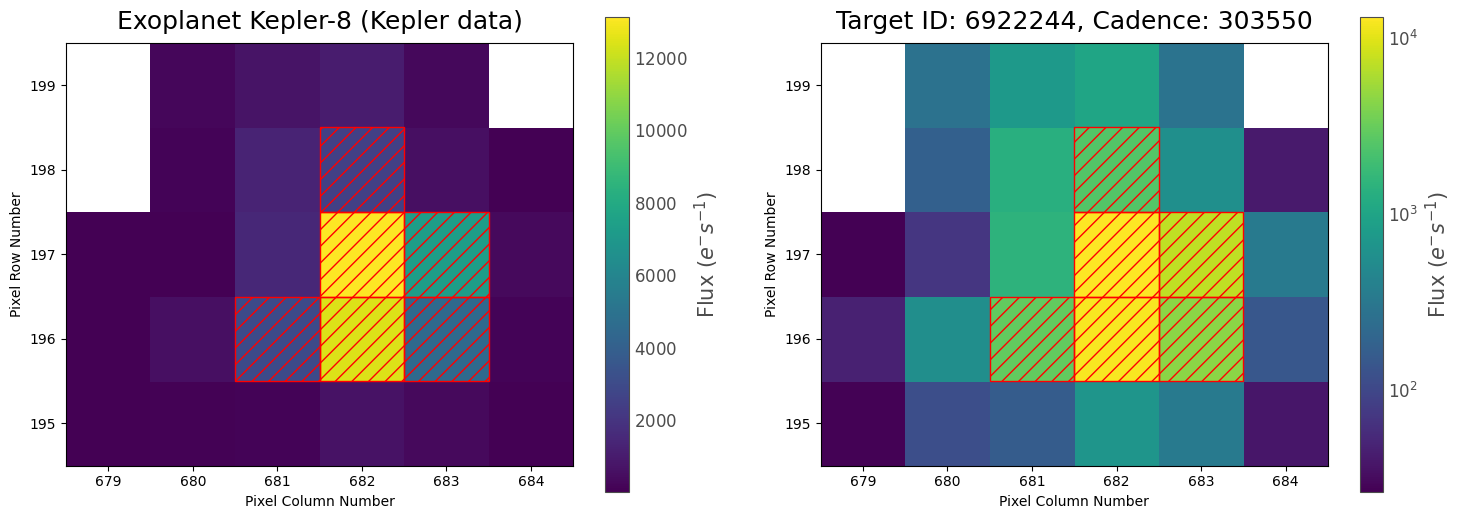

In [6]:
# Visualize Kepler
fig, axes = plt.subplots(1, 2, figsize=(14,6))
tpf_kep.plot(ax=axes[0], aperture_mask=tpf_kep.pipeline_mask, title=f"Exoplanet {target} (Kepler data)")
tpf_kep.plot(ax=axes[1], aperture_mask=tpf_kep.pipeline_mask, scale='log')
fig.tight_layout()
fig.set_size_inches(15, 5)

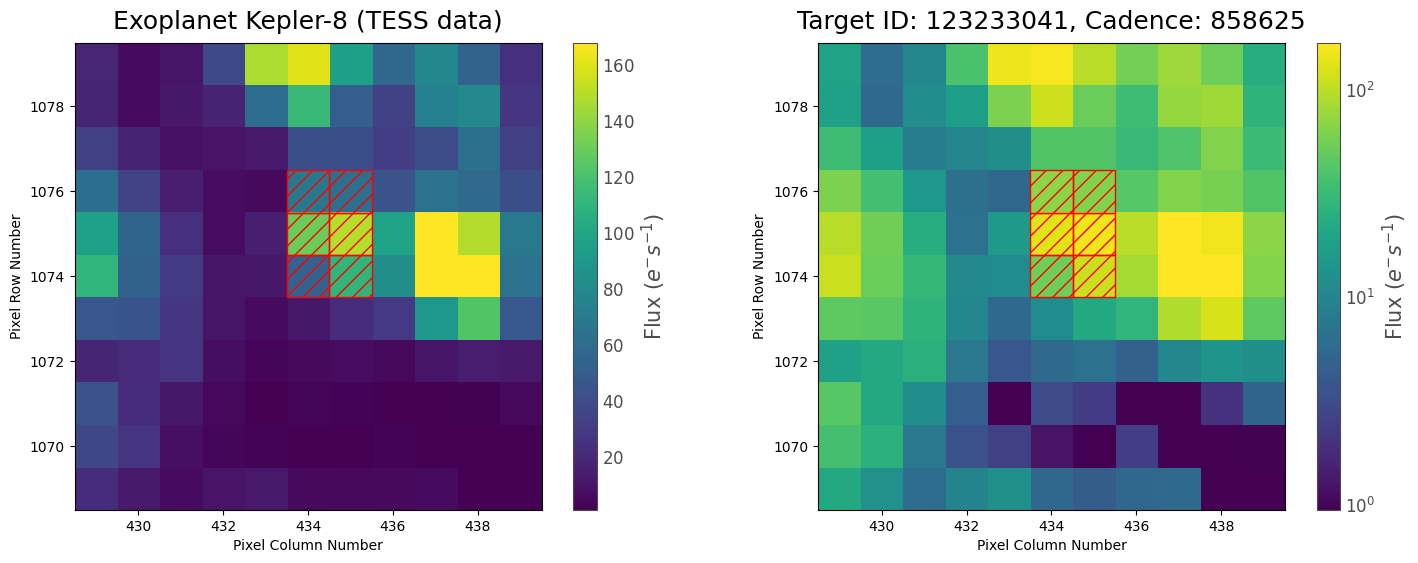

In [ ]:
# Visualize TESS
fig, axes = plt.subplots(1, 2, figsize=(14,6))
tpf_tess.plot(ax=axes[0], aperture_mask=tpf_tess.pipeline_mask, title=f"Exoplanet {target} (TESS data)")
tpf_tess.plot(ax=axes[1], aperture_mask=tpf_tess.pipeline_mask, scale='log')
fig.tight_layout()
fig.set_size_inches(15, 5)

In [ ]:
# Animate Exoplanet Movement via Host Star Brightness over Time (TESS data)
tpf_tess.animate()

###### <font color="blue">*Transit Fitting and Period Finding (Kepler)*

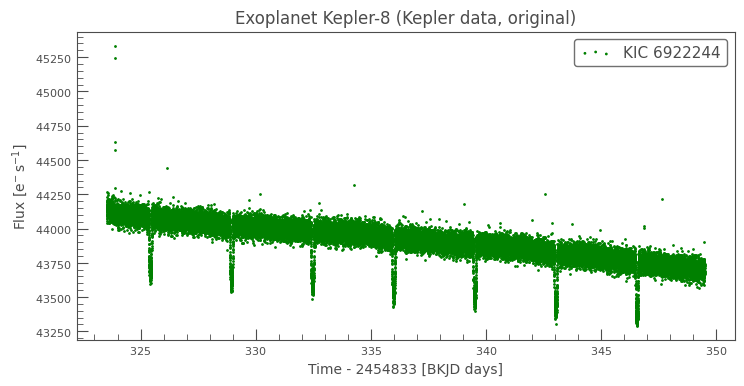

In [30]:
# Plot Original Kepler Data
ax = tpf_kep.to_lightcurve().scatter(color='green')
ax.set_xlabel(ax.get_xlabel(), fontsize=10)
ax.set_ylabel(ax.get_ylabel(), fontsize=10)
plt.title(f"Exoplanet {target} (Kepler data, original)", fontsize=12)
ax.tick_params(axis='both', labelsize=8)

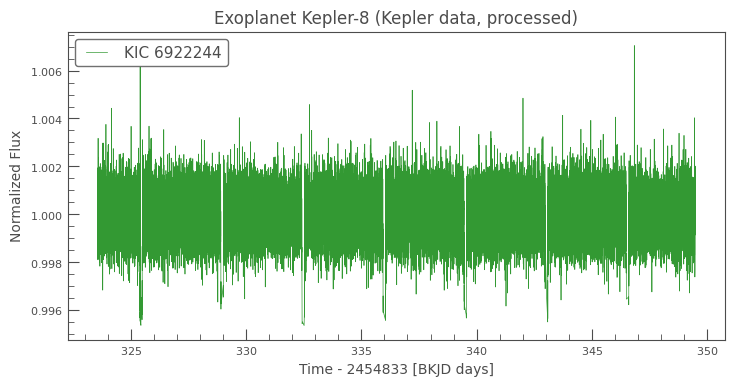

In [31]:
# Plot Preprocessed Kepler Data (outliers removed, normalized)
ax = tpf_kep.to_lightcurve(method="pld").remove_outliers().flatten().plot(c='green', alpha=.8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10)
ax.set_ylabel(ax.get_ylabel(), fontsize=10)
plt.title(f"Exoplanet {target} (Kepler data, processed)", fontsize=12)
ax.tick_params(axis='both', labelsize=8)

In [26]:
# Create Periodogram data - takes some time to process (Kepler data)
periodogram = tpf_kep.to_lightcurve(method="pld").remove_outliers().flatten()
print(f"\nPeriodogram successfully created - ready for analysis.. ✅")


Periodogram successfully created.. ✅


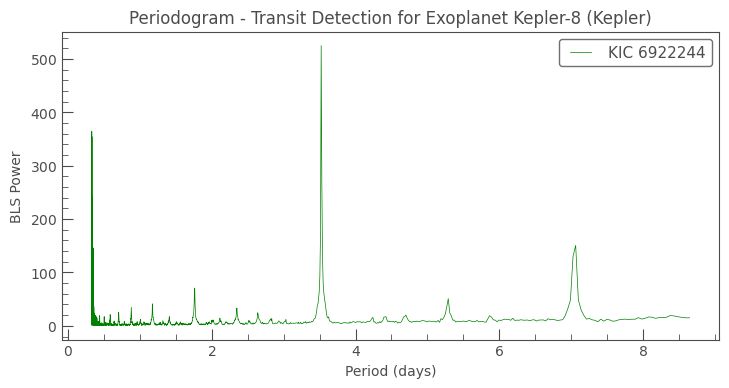

In [19]:
# Periodogram for Transit Detection (Kepler)
ax = periodogram.to_periodogram("bls").plot(color='green') #minimum_period=0.4, maximum_period=25
# Box Least Squares to find periodic dips in brightness to indicates planetary transits
plt.title(f"Periodogram - Transit Detection for Exoplanet {target} (Kepler)", fontsize=12)
ax.set_xlabel("Period (days)", fontsize=10)
ax.set_ylabel("BLS Power", fontsize=10)
ax.tick_params(axis='both', labelsize=10)

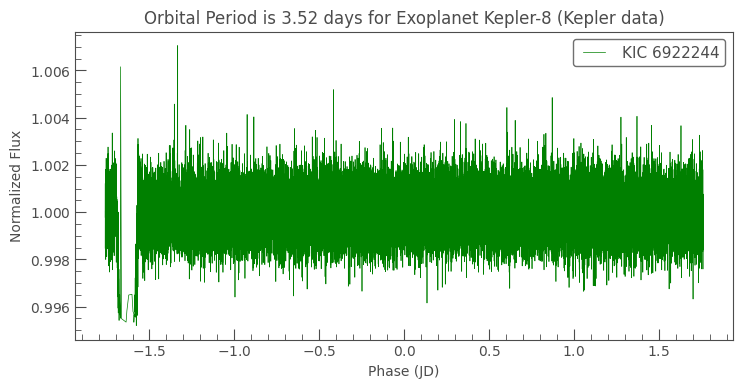

In [21]:
# Calculate Orbital Period at Max Power (where dips in light curve lined up most perfectly)
bls = periodogram.to_periodogram("bls")
period = bls.period_at_max_power
ax = periodogram.fold(period).plot(color='green')
ax.set_title(f"Orbital Period is {period.value:.2f} days for Exoplanet {target} (Kepler data)", fontsize=12)
ax.set_xlabel("Phase (JD)", fontsize=10)
ax.set_ylabel("Normalized Flux", fontsize=10)
ax.tick_params(axis='both', labelsize=10)

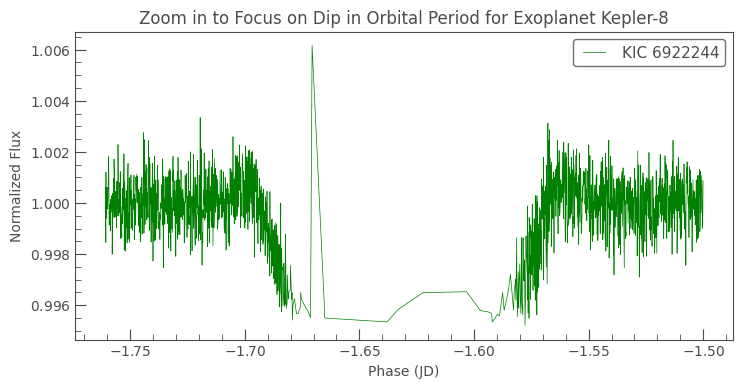

In [ ]:
# Zoom in and focus on dip
ax = periodogram.fold(period).truncate(-2.0, -1.5).plot(color='green')
ax.set_title(f"Zoom in to Focus on Dip in Orbital Period for Exoplanet {target}", fontsize=12)
ax.set_xlabel("Phase (JD)", fontsize=10)
ax.set_ylabel("Normalized Flux", fontsize=10)
ax.tick_params(axis='both', labelsize=10)

In [72]:
######################################################################################
# Transit Depth - How much of star's brightness drops as planet passes in front of star?
######################################################################################
print(75*"=" + f"\nTransit Depth, Limb Darkening and Impact Parameter for Exoplanet {target}" + "\n" + 75*"-")
print(f"\n🪐 Transit Depth calculation from Periodogram" + "\n" + 75*"-")
print(f"Best-fit period:            {periodogram.to_periodogram("bls").period_at_max_power:.2f} days")
print(f"Best-fit transit duration:  {periodogram.to_periodogram("bls").duration_at_max_power:.2f} days")
print(f"Transit Depth:              {periodogram.to_periodogram("bls").depth_at_max_power:.4f} relative flux" + "\n" + 75*"-")
transit_depth_percent = ((periodogram.to_periodogram("bls").depth_at_max_power)) * 100
print(f"Star brightness drops by {transit_depth_percent.value:.2f}% when exoplanet passes" + "\n" + 75*"=")
print(f"\n☀️ Limb Darkening and Impact Parameter" + "\n" + 75*"-")
print("* Limb Darkening means: 'How much is exoplanet crossing of the way from center to edge?'")
print("* A star is not uniform disk, that is, equally bright everywhere, but less on edges")
impact = data['pl_imppar'][0]
impact_percent = (impact) * 100
print(f"* We can calculate Limb Darkening with the Impact Parameter = {impact}")
print("* Represents minimum distance between center of exoplanet and center of host star during transit (in units of stellar radius R_s)")
print("* Geometrically, if b=0, the planet passes exactly through the center of star. If b=1, planet just grazes the edge.")
print(75*"-" + "\n" + f"The exoplanet is passing {impact_percent}% of way from center toward edge of host star" + "\n" + 75*"=")
print("\n" + f"This means the planet does not cross the center of the star, but follows a chord roughly {impact_percent}% of the way")
print("toward the stellar limb (edge). Because the star is dimmer at the edges due to Limb Darkening, a planet crossing")
print("at a higher impact parameter produces a different light curve shape than one crossing the bright center.")
print("\n" + "Because the star is dimmer at the edges due to Limb Darkening, a planet crossing at a higher impact parameter")
print("produces a more V-shaped light curve compared to the U-shape of a central crossing.")

Transit Depth, Limb Darkening and Impact Parameter for Exoplanet Kepler-8
---------------------------------------------------------------------------

🪐 Transit Depth calculation from Periodogram
---------------------------------------------------------------------------
Best-fit period:            3.52 d days
Best-fit transit duration:  0.10 d days
Transit Depth:              0.0032 relative flux
---------------------------------------------------------------------------
Star brightness drops by 0.32% when exoplanet passes

☀️ Limb Darkening and Impact Parameter
---------------------------------------------------------------------------
* Limb Darkening means: 'How much is exoplanet crossing of the way from center to edge?'
* A star is not uniform disk, that is, equally bright everywhere, but less on edges
* We can calculate Limb Darkening with the Impact Parameter = 0.6141
* Represents minimum distance between center of exoplanet and center of host star during transit (in units of st

<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

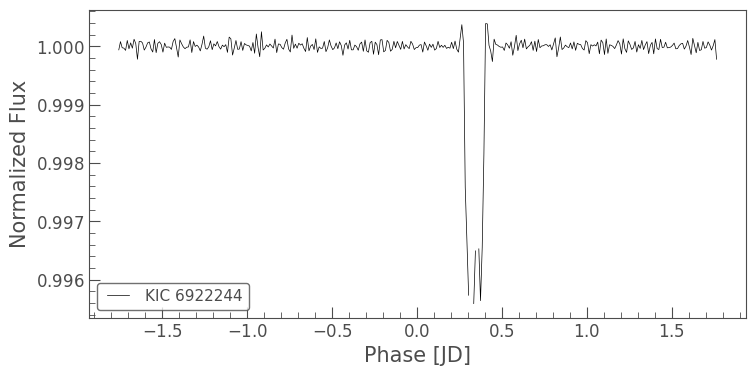

In [ ]:
# Try centering your fold on the actual transit midpoint to see the shape
t0 = data['pl_tranmid'][0]
periodogram.fold(period, epoch_time=t0).bin(time_bin_size=0.01).plot(color='black')

###### <font color="blue">*Load TPF File Details from Kepler and TESS*

In [16]:
print("\n" + 85*"-" + f"\n📂 Load details from Kepler TPF file\n" + 85*"-")
tpf_kep.get_header(ext=0)


-------------------------------------------------------------------------------------
📂 Load details from Kepler TPF file
-------------------------------------------------------------------------------------


SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2016-05-26'         / file creation date.                            
CREATOR = '1199650 TargetPixelExporterPipelineModule' / pipeline job and program
PROCVER = 'svn+ssh://murzim/repo/soc/tags/release/9.3.47 r61408' / SW version   
FILEVER = '6.1     '           / file format version                            
TIMVERSN= 'OGIP/93-003'     

In [ ]:
print("\n" + 85*"-" + f"\n📂 Load details from TESS TPF file\n" + 85*"-")
tpf_tess.get_header(ext=0)